In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [7]:
x = torch.randn((1,10))

In [8]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[8.9301e-02, 5.8796e-02, 7.8390e-01, 6.7826e-06, 1.4120e-14, 3.9692e-06,
          7.9713e-04, 6.5696e-02, 1.4955e-03, 1.8849e-07]]),
 tensor([[0.1787, 0.1644, 0.2759, 0.0268, 0.0005, 0.0241, 0.0695, 0.1681, 0.0789,
          0.0131]]),
 tensor([[0.1530, 0.1467, 0.1901, 0.0592, 0.0080, 0.0562, 0.0954, 0.1483, 0.1016,
          0.0414]]))

In [9]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [10]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [11]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [12]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

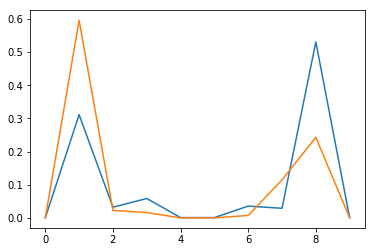

In [13]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

In [14]:
class AbsInferno(AbsCallback):
    def __init__(self, n:int, true_mu:float, n_alphas:int=0, aug_alpha:bool=False):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): self.alpha[0] = self.true_mu
                
    def on_batch_begin(self) -> None:
        if self.aug_alpha:
            self.rand = torch.randn_like(self.alpha, device=self.wrapper.device)/10
            with torch.no_grad(): self.alpha += self.rand
        self.wrapper.x = self.aug_data(self.wrapper.x)
    
    def on_batch_end(self) -> None:
        if self.aug_alpha:
             with torch.no_grad(): self.alpha -= self.rand
        self.alpha.grad.data.zero_()
    
    @abstractmethod
    def aug_data(self, x:Tensor) -> Tensor: pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor) -> Tensor:  
        nll = calc_nll(s_exp=self.alpha[0], alpha=self.alpha[1:], s_true=self.true_mu, b_true=self.true_b,
                       f_s=f_s, f_b_nom=f_b, f_b_up=None, f_b_dw=None)
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
        ikk = torch.inverse(h)[0,0]
#         print(h,ikk)
        return ikk
        
    def on_forwards_end(self) -> None:
        def to_shape(p:Tensor) -> Tensor:
            f = p.sum(0)+1e-7
            return f/f.sum()
        
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b)

In [15]:
class PaperInferno(AbsInferno):
    def __init__(self, float_r:bool, float_l:bool, l_init:float=3, n:int=1050, true_mu:int=50, aug_alpha:bool=False):
        super().__init__(n=n, true_mu=true_mu, n_alphas=float_r+float_l, aug_alpha=aug_alpha)
        self.float_r,self.float_l,self.l_init = float_r,float_l,l_init
        
    def on_train_begin(self) -> None:
        super().on_train_begin()
#         if self.float_l:
#             with torch.no_grad(): self.alpha[-1] = 1
        
    def aug_data(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        i = 1
        if self.float_r:
            x[:,0] += self.alpha[i]
            i += 1
        if self.float_l:
            x[:,2] *= (self.alpha[i]+self.l_init)/self.l_init
        return x

In [16]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [17]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=0, float_l=1, aug_alpha=False),LossTracker(),SaveBest('weights/best_ie1l.h5'),EarlyStopping(10)])

1: Train=451.3694140625 Valid=392.1666638183594
2: Train=373.17552307128904 Valid=372.1685968017578
3: Train=357.0025622558594 Valid=352.846005859375
4: Train=339.1401715087891 Valid=340.53924682617185
5: Train=329.8262094116211 Valid=333.11225952148436
6: Train=324.2759596252441 Valid=328.57863037109377
7: Train=319.99149200439456 Valid=324.00316955566404
8: Train=315.90166931152345 Valid=320.7999963378906
9: Train=312.80955627441404 Valid=317.22758056640623
10: Train=309.9976136779785 Valid=313.91990478515623
11: Train=305.9430258178711 Valid=310.61080261230467
12: Train=304.13693969726563 Valid=307.4541845703125
13: Train=301.48649139404296 Valid=304.9738720703125
14: Train=299.3406599426269 Valid=302.49622131347655
15: Train=295.9239039611816 Valid=299.7528771972656
16: Train=294.11014251708986 Valid=297.7457086181641
17: Train=291.6915953063965 Valid=295.6281768798828
18: Train=289.62848709106447 Valid=293.25486145019534
19: Train=287.7996653747559 Valid=291.95443237304687
20: Tra

155: Train=245.0415299987793 Valid=251.6192153930664
156: Train=245.27083435058594 Valid=251.7389422607422
157: Train=245.2630857849121 Valid=251.29357879638673
158: Train=244.9049905395508 Valid=251.8083367919922
159: Train=245.17544174194336 Valid=251.4647067260742
160: Train=245.482216796875 Valid=251.30804718017578
161: Train=244.9777816772461 Valid=251.09767486572267
162: Train=244.89156448364258 Valid=251.3540805053711
163: Train=244.98877655029298 Valid=251.28892181396483
164: Train=244.89972930908203 Valid=250.8483935546875
165: Train=245.28588409423827 Valid=251.42130432128906
166: Train=245.08479888916017 Valid=250.73138580322265
167: Train=245.45488357543945 Valid=251.28012084960938
168: Train=245.01422561645506 Valid=250.9683395385742
169: Train=244.77432235717774 Valid=250.63817657470702
170: Train=244.53422058105468 Valid=250.85886138916015
171: Train=244.61453079223634 Valid=250.7427243041992
172: Train=244.5985140991211 Valid=250.99004272460937
173: Train=244.0479673767

In [18]:
model.save('weights/Inferno_Test_exact_bm1l.h5')

model.load('weights/Inferno_Test_exact_bm1.h5')

# Results

In [19]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [20]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [21]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,2,1.0
1,2,1.0
2,2,1.0
3,3,1.0
4,5,1.0


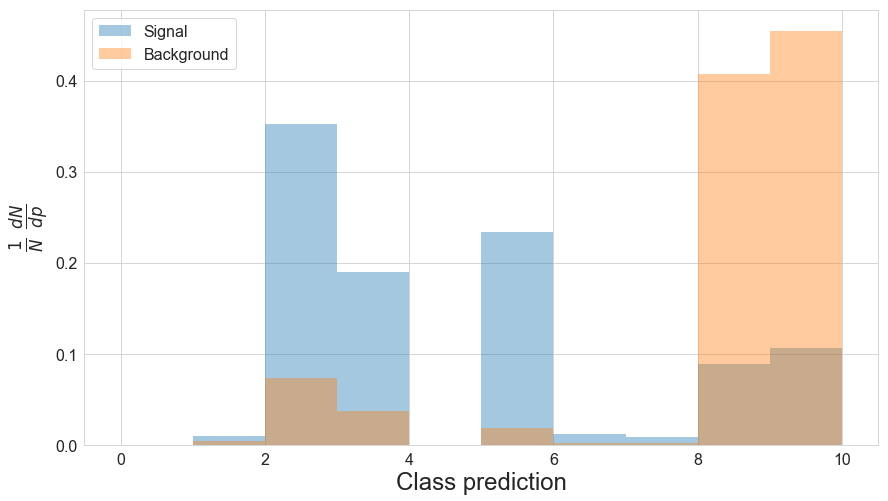

In [22]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [23]:
bin_preds(df)

In [24]:
df.head()

,pred,gen_target,pred_bin
0,2,1.0,2
1,2,1.0,2
2,2,1.0,2
3,3,1.0,3
4,5,1.0,5


In [25]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [26]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [27]:
f_s, f_b

(tensor([9.7760e-03, 3.5235e-01, 1.8947e-01, 2.0000e-13, 2.3389e-01, 1.1938e-02,
         8.2380e-03, 8.8552e-02, 1.0578e-01, 2.0000e-13]),
 tensor([3.9300e-03, 7.3884e-02, 3.7566e-02, 2.0000e-13, 1.8026e-02, 1.9120e-03,
         2.3780e-03, 4.0744e-01, 4.5487e-01, 2.0000e-13]))

In [28]:
asimov = (50*f_s)+(1000*f_b)

In [29]:
asimov, asimov.sum()

(tensor([4.4188e+00, 9.1501e+01, 4.7040e+01, 2.1000e-10, 2.9720e+01, 2.5089e+00,
         2.7899e+00, 4.1187e+02, 4.6016e+02, 2.1000e-10]), tensor(1050.0001))

In [30]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([23.20323753, 23.0571804 , 22.91731071, 22.78274536, 22.65418053,
       22.5315094 , 22.41420555, 22.30260086, 22.19649315, 22.09571266,
       22.00022507, 21.90987206, 21.82522202, 21.74511719, 21.67054558,
       21.60037994, 21.53584671, 21.47561264, 21.42042542, 21.36987877,
       21.32394028, 21.28261185, 21.24586105, 21.21404648, 21.18605423,
       21.16300201, 21.14400673, 21.12900162, 21.11864853, 21.1125412 ,
       21.11072159, 21.11249542, 21.11857033, 21.12883377, 21.14274597,
       21.16106224, 21.18276405, 21.20869827, 21.23796844, 21.27139282,
       21.30875778, 21.34900093, 21.39338493, 21.44202805, 21.49322891,
       21.54817772, 21.60682678, 21.66909218, 21.73430824, 21.80291176,
       21.87525177, 21.95144653, 22.02977753, 22.1117115 , 22.19724846,
       22.2857666 , 22.37733078, 22.47229195, 22.57032394, 22.67140388,
       22.77549553])

In [31]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [32]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

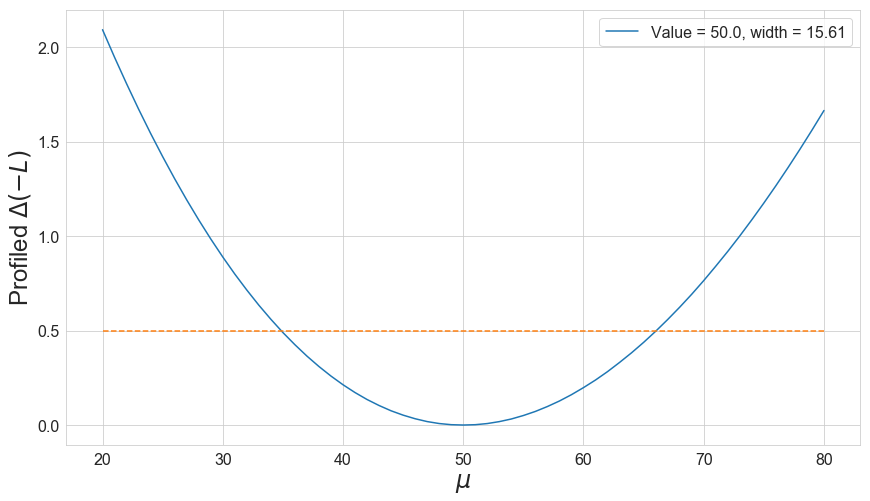

In [33]:
plot_likelihood(y-y.min())

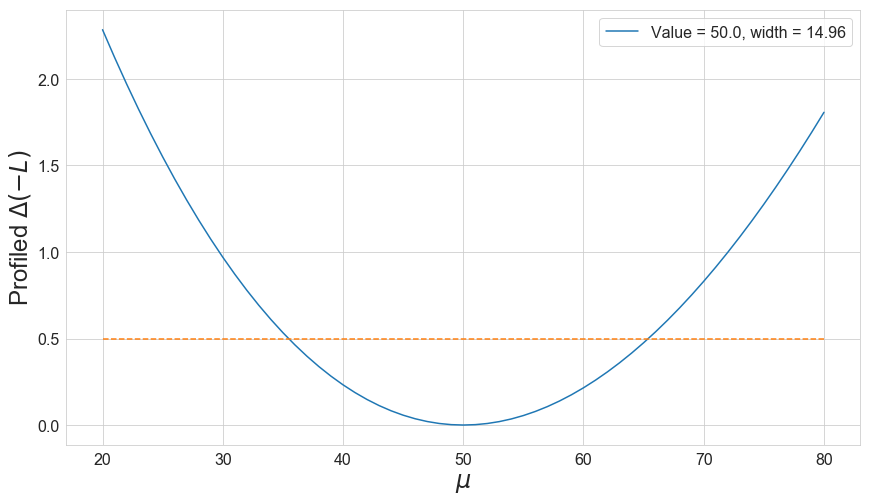

In [34]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [35]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [36]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [37]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,2,1.0,2,2,2,2,2,2,2,2,2,2,2
1,2,1.0,2,2,2,2,2,2,2,2,2,2,2
2,2,1.0,2,2,2,2,2,2,2,2,2,2,2
3,3,1.0,3,3,3,3,3,3,3,3,3,3,3
4,5,1.0,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2,0.0,2,2,2,2,2,2,2,2,2,2,2
999996,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999997,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999998,9,0.0,9,9,9,9,9,9,9,9,9,9,9


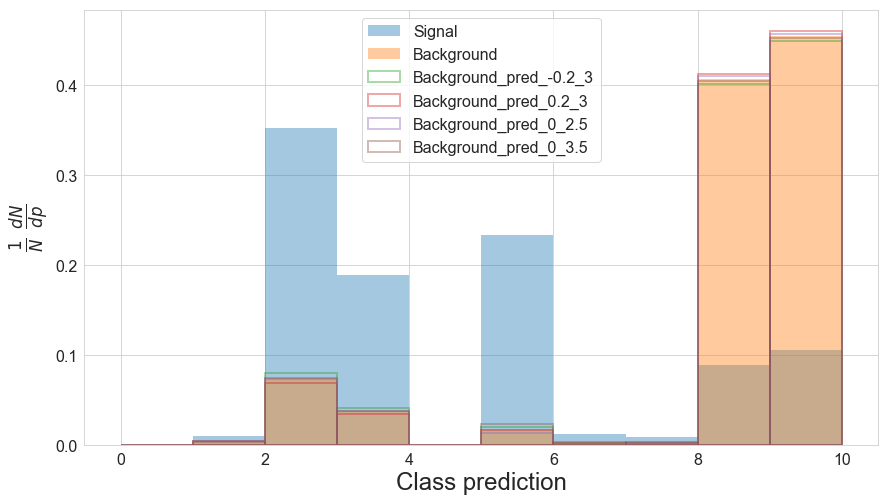

In [38]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([4.7860e-03, 7.8582e-02, 4.1264e-02, 2.0000e-13, 1.5192e-02, 9.6800e-04,
        2.8200e-03, 4.0431e-01, 4.5208e-01, 2.0000e-13])
tensor([4.1840e-03, 7.9378e-02, 4.1360e-02, 2.0000e-13, 1.9696e-02, 1.8460e-03,
        2.5620e-03, 4.0153e-01, 4.4945e-01, 2.0000e-13])
tensor([3.7440e-03, 7.9704e-02, 4.1350e-02, 2.0000e-13, 2.4456e-02, 2.8160e-03,
        2.3220e-03, 3.9840e-01, 4.4721e-01, 2.0000e-13])
tensor([4.5320e-03, 7.3088e-02, 3.7470e-02, 2.0000e-13, 1.3522e-02, 1.0340e-03,
        2.6360e-03, 4.1022e-01, 4.5750e-01, 2.0000e-13])
tensor([3.9300e-03, 7.3884e-02, 3.7566e-02, 2.0000e-13, 1.8026e-02, 1.9120e-03,
        2.3780e-03, 4.0744e-01, 4.5487e-01, 2.0000e-13])
tensor([3.4900e-03, 7.4210e-02, 3.7556e-02, 2.0000e-13, 2.2786e-02, 2.8820e-03,
        2.1380e-03, 4.0431e-01, 4.5263e-01, 2.0000e-13])
tensor([4.3920e-03, 6.7602e-02, 3.3900e-02, 2.0000e-13, 1.1790e-02, 9.7600e-04,
        2.4280e-03, 4.1545e-01, 4.6346e-01, 2.0000e-13])
tensor([3.7900e-03, 6.8398e-02, 3.3996e-0

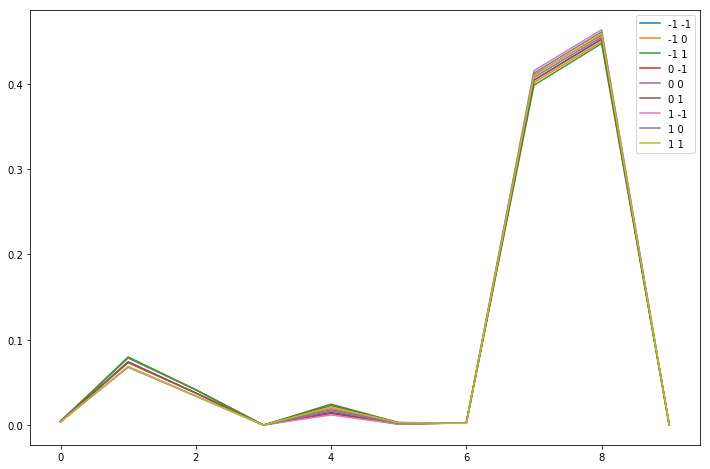

In [39]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [40]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [41]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [42]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [43]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

Linear regime: Mu 20.0, alpha tensor([-1.6181])
Linear regime: Mu 21.0, alpha tensor([-1.5629])
Linear regime: Mu 22.0, alpha tensor([-1.5078])
Linear regime: Mu 23.0, alpha tensor([-1.4528])
Linear regime: Mu 24.0, alpha tensor([-1.3979])
Linear regime: Mu 25.0, alpha tensor([-1.3430])
Linear regime: Mu 26.0, alpha tensor([-1.2883])
Linear regime: Mu 27.0, alpha tensor([-1.2337])
Linear regime: Mu 28.0, alpha tensor([-1.1791])
Linear regime: Mu 29.0, alpha tensor([-1.1247])
Linear regime: Mu 30.0, alpha tensor([-1.0703])
Linear regime: Mu 31.0, alpha tensor([-1.0153])
Linear regime: Mu 69.0, alpha tensor([1.0380])
Linear regime: Mu 70.0, alpha tensor([1.0921])
Linear regime: Mu 71.0, alpha tensor([1.1460])
Linear regime: Mu 72.0, alpha tensor([1.1999])
Linear regime: Mu 73.0, alpha tensor([1.2538])
Linear regime: Mu 74.0, alpha tensor([1.3076])
Linear regime: Mu 75.0, alpha tensor([1.3613])
Linear regime: Mu 76.0, alpha tensor([1.4150])
Linear regime: Mu 77.0, alpha tensor([1.4687])
L

In [44]:
nll = to_np(nll)

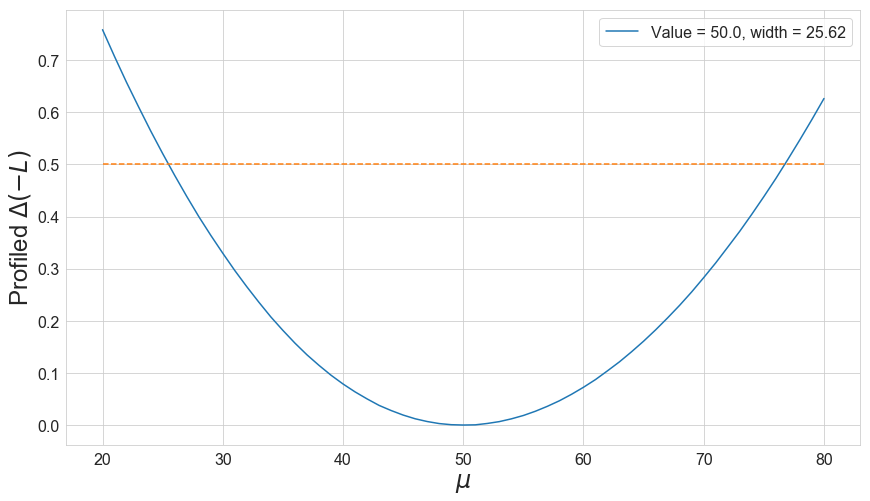

In [45]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [46]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [47]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 20.0, alpha tensor([1.0246])
Linear regime: Mu 80.0, alpha tensor([-1.0004])


In [48]:
nll = to_np(nll)

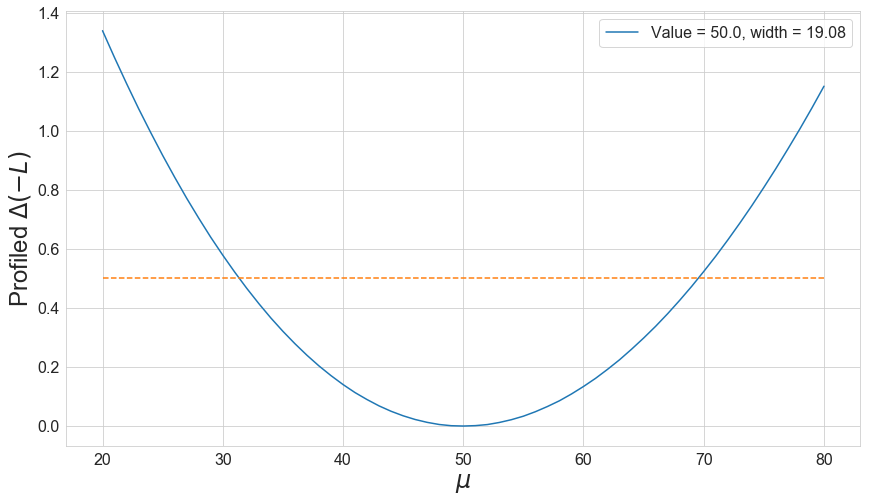

In [49]:
plot_likelihood(nll-nll.min())

## BM 2

In [50]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-1.3674,  0.6738])
Linear regime: Mu 21.0, alpha tensor([-1.3216,  0.6514])
Linear regime: Mu 22.0, alpha tensor([-1.2759,  0.6289])
Linear regime: Mu 23.0, alpha tensor([-1.2302,  0.6065])
Linear regime: Mu 24.0, alpha tensor([-1.1844,  0.5840])
Linear regime: Mu 25.0, alpha tensor([-1.1387,  0.5616])
Linear regime: Mu 26.0, alpha tensor([-1.0930,  0.5391])
Linear regime: Mu 27.0, alpha tensor([-1.0474,  0.5167])
Linear regime: Mu 28.0, alpha tensor([-1.0017,  0.4942])
Linear regime: Mu 72.0, alpha tensor([ 1.0351, -0.4211])
Linear regime: Mu 73.0, alpha tensor([ 1.0821, -0.4399])
Linear regime: Mu 74.0, alpha tensor([ 1.1291, -0.4587])
Linear regime: Mu 75.0, alpha tensor([ 1.1761, -0.4774])
Linear regime: Mu 76.0, alpha tensor([ 1.2231, -0.4961])
Linear regime: Mu 77.0, alpha tensor([ 1.2700, -0.5148])
Linear regime: Mu 78.0, alpha tensor([ 1.3170, -0.5335])
Linear regime: Mu 79.0, alpha tensor([ 1.3639, -0.5521])
Linear regime: Mu 80.0, alpha t

In [51]:
nll = to_np(nll)

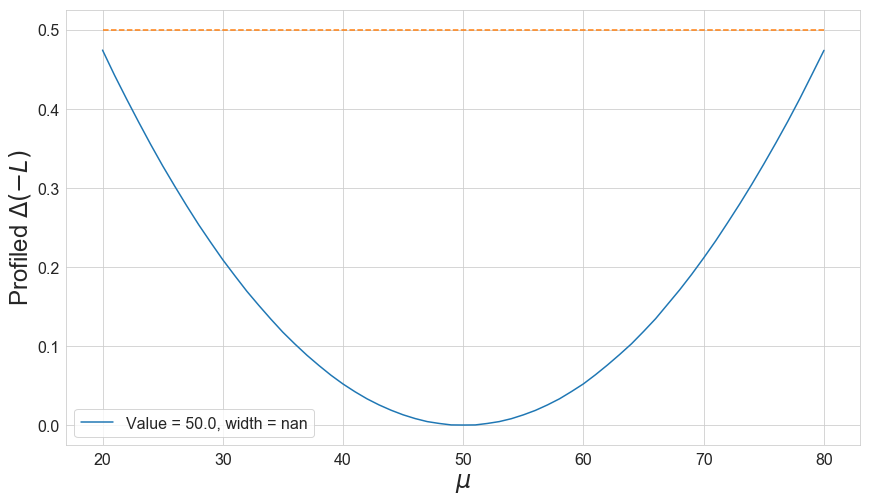

In [52]:
plot_likelihood(nll-nll.min())